# Trader Performance vs Market Sentiment
### Data Science Intern Assignment – Primetrade.ai

**Author:** Satyam  
**Tool:** Google Colab  
**Objective:** Analyze how market sentiment (Fear vs Greed) impacts trader behavior and performance.

In [1]:
import pandas as pd
import numpy as np

## Data Loading , Inspection , Data Understanding

In [2]:
fear_greed = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.csv")

In [3]:
fear_greed.shape

(2644, 4)

## Interpretation (important):

 Rows = 2644

Columns = 4

In [4]:
trades.shape

(211224, 16)

 ### Interpretation (important):
Rows = 211224

Columns = 16

In [5]:
fear_greed.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [6]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


## Trade Dataset — Column Description & Relevance

Each row in the dataset represents a single executed trade on the Hyperliquid exchange.

| Column Name | Description | Relevance |
|------------|------------|-----------|
| Account | Unique identifier of the trader (wallet address) | **Critical** – used to group trades by trader |
| Coin | Asset being traded | Low – not required for sentiment-level analysis |
| Execution Price | Price at which the trade was executed | Low – optional for deeper price analysis |
| Size Tokens | Quantity of asset traded (in tokens) | Medium – helps estimate position size |
| Size USD | Monetary value of the trade in USD | Medium – easier interpretation of trade size |
| Side | Trade action (BUY / SELL) | **Critical** – used to analyze long/short behavior |
| Timestamp IST | Time at which the trade occurred (IST) | **Critical** – used for daily aggregation and alignment |
| Timestamp | Blockchain timestamp (numeric) | Low – not used due to poor readability |
| Start Position | Position size before this trade | Low – optional, not required for core analysis |
| Direction | Trade direction (same as Side) | Low – redundant column |
| Closed PnL | Realized profit or loss from the trade | **Critical** – primary performance metric |
| Transaction Hash | Blockchain transaction identifier | None – metadata only |
| Order ID | Internal order identifier | None – metadata only |
| Trade ID | Unique trade identifier | None – metadata only |
| Crossed | Indicates whether order crossed the order book | None – not relevant |
| Fee | Trading fee paid for the transaction | Low – ignored in current analysis |


## Bitcoin Fear & Greed Sentiment Dataset — Feature Description

This dataset captures daily Bitcoin market sentiment using the widely followed Fear & Greed Index. Each row represents the market sentiment for a specific calendar day.

| Column Name | Description | Relevance |
|------------|------------|-----------|
| timestamp | Unix timestamp representing the date of sentiment measurement | Low – raw time format, not used directly |
| value | Numerical Fear & Greed Index score (typically ranging from 0 to 100) | Medium – indicates intensity of market emotion |
| classification | Categorical sentiment label (e.g., Fear, Extreme Fear) | **Critical** – primary sentiment indicator used in analysis |
| date | Human-readable calendar date (YYYY-MM-DD) | **Critical** – used to align sentiment with daily trader activity |



In [7]:
fear_greed["datetime"] = pd.to_datetime(fear_greed["timestamp"], unit="s") # converts the timestamp to human readable timestamp
fear_greed["date"] = fear_greed["datetime"].dt.date

In [8]:
fear_greed['datetime']

,datetime
0,2018-02-01 05:30:00
1,2018-02-02 05:30:00
2,2018-02-03 05:30:00
3,2018-02-04 05:30:00
4,2018-02-05 05:30:00
...,...
2639,2025-04-28 05:30:00
2640,2025-04-29 05:30:00
2641,2025-04-30 05:30:00
2642,2025-05-01 05:30:00


### Data Cleaning , Transforming

In [9]:
fear_greed["sentiment"] = fear_greed["classification"].replace({
    "Extreme Fear": "Fear",
    "Extreme Greed": "Greed"
}) ## Simplying the labels

In [17]:
fear_greed_clean = fear_greed[["date", "sentiment"]]

In [18]:
fear_greed_clean = fear_greed_clean.drop_duplicates()

In [19]:
fear_greed_clean.head()

,date,sentiment
0,2018-02-01,Fear
1,2018-02-02,Fear
2,2018-02-03,Fear
3,2018-02-04,Fear
4,2018-02-05,Fear


In [12]:
trades["datetime"] = pd.to_datetime(
    trades["Timestamp IST"],
    dayfirst=True
)
trades[["Timestamp IST", "datetime"]].head()


,Timestamp IST,datetime
0,02-12-2024 22:50,2024-12-02 22:50:00
1,02-12-2024 22:50,2024-12-02 22:50:00
2,02-12-2024 22:50,2024-12-02 22:50:00
3,02-12-2024 22:50,2024-12-02 22:50:00
4,02-12-2024 22:50,2024-12-02 22:50:00


In [13]:
trades["date"] = trades["datetime"].dt.date ## Exctracting the date from the datetime feature


In [14]:
trades.columns = trades.columns.str.lower().str.replace(" ", "_") #cleaning the str type column names

In [15]:
trades_clean = trades[[
    "account",
    "date",
    "side",
    "size_usd",
    "closed_pnl"
]]  ## Only relevant crucial columns are kept

In [16]:
trades_clean["closed_pnl"] = trades_clean["closed_pnl"].fillna(0)  ## filling the null values


/tmp/ipython-input-543053648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades_clean["closed_pnl"] = trades_clean["closed_pnl"].fillna(0)


In [20]:
## Merging  Trader Data with Sentiment Data
merged_df = trades_clean.merge(
    fear_greed_clean,
    on="date",
    how="left"
)

In [21]:
merged_df.head()

,account,date,side,size_usd,closed_pnl,sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-12-02,BUY,7872.16,0.0,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-12-02,BUY,127.68,0.0,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-12-02,BUY,1150.63,0.0,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-12-02,BUY,1142.04,0.0,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-12-02,BUY,69.75,0.0,Greed


In [22]:
merged_df["sentiment"].isna().sum()

np.int64(6)

Rows corresponding to trade dates without available market sentiment data were removed to ensure consistency in sentiment-based analysis.


In [23]:
merged_df = merged_df.dropna(subset=["sentiment"])
merged_df["sentiment"].isna().sum()

np.int64(0)

## Feature Engineering

In [27]:
daily_pnl = (
    merged_df
    .groupby(["account", "date", "sentiment"])["closed_pnl"]
    .sum()
    .reset_index()
)  ## Adding  pnl values of each trader based on date and sentiment


In [24]:
daily_trades = (
    merged_df
    .groupby(["account", "date"])
    .size()
    .reset_index(name="num_trades")
)  ## Gives the count of trades per day

In [25]:
daily_side = (
    merged_df
    .groupby(["account", "date", "side"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)   # Getting the coynt of BUY and SELL on a daily basis for individual traders

In [29]:
daily_df = daily_pnl.merge(
    daily_trades, on=["account", "date"]
)

daily_df = daily_df.merge(
    daily_side, on=["account", "date"]
)  ## Merging all in a new df

In [30]:
daily_df.head()

,account,date,sentiment,closed_pnl,num_trades,BUY,SELL
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Greed,0.0,177,0,177
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,Greed,0.0,68,0,68
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,Greed,0.0,40,0,40
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,Greed,-21227.0,12,12,0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,Greed,1603.1,27,12,15


Trade-level data was aggregated to a daily trader level, resulting in a dataset where each row represents a trader’s daily performance and behavior. This includes total daily PnL, number of trades, and directional activity (BUY vs SELL), aligned with the market sentiment of that day.


In [32]:
## LONG SHORT RATIO
daily_df["long_short_ratio"] = daily_df["BUY"] / (daily_df["SELL"] + 1)
daily_df.head()

,account,date,sentiment,closed_pnl,num_trades,BUY,SELL,long_short_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Greed,0.0,177,0,177,0.00
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,Greed,0.0,68,0,68,0.00
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,Greed,0.0,40,0,40,0.00
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,Greed,-21227.0,12,12,0,12.00
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,Greed,1603.1,27,12,15,0.75


Directional bias was quantified using the long–short ratio, defined as the number of BUY trades divided by the number of SELL trades per trader per day.

In [35]:
daily_df["is_win"] = (daily_df["closed_pnl"] > 0).astype(int)  ##A “win” = a trader-day where daily PnL > 0

In [34]:
loss_threshold = daily_df["closed_pnl"].quantile(0.05)

daily_df["large_loss"] = (
    daily_df["closed_pnl"] <= loss_threshold
).astype(int)

In [36]:
daily_df.head()

,account,date,sentiment,closed_pnl,num_trades,BUY,SELL,long_short_ratio,is_win,large_loss
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Greed,0.0,177,0,177,0.00,0,0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,Greed,0.0,68,0,68,0.00,0,0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,Greed,0.0,40,0,40,0.00,0,0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,Greed,-21227.0,12,12,0,12.00,0,1
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,Greed,1603.1,27,12,15,0.75,1,0


PnL Performance during Fear and Greed days


In [37]:
daily_df.groupby("sentiment")["closed_pnl"].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
Fear,790.0,5185.146443,31224.148764,-108604.496278,0.0,122.737038,2149.388240,533974.662903
Greed,1174.0,4144.208334,29252.037677,-358963.139984,0.0,265.247725,1865.257051,449328.107544
Neutral,376.0,3438.618818,17447.863645,-113601.020138,0.0,167.551743,1321.966347,194499.072534


In [38]:
daily_df.groupby("sentiment")["closed_pnl"].agg(
    mean_pnl="mean",
    median_pnl="median"
)

,mean_pnl,median_pnl
sentiment,,
Fear,5185.146443,122.737038
Greed,4144.208334,265.247725
Neutral,3438.618818,167.551743


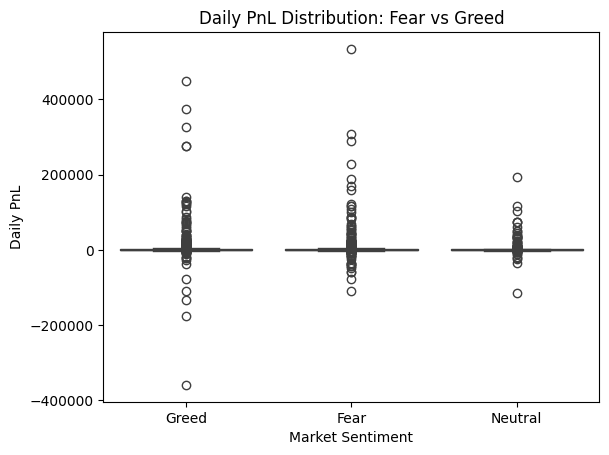

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=daily_df,
    x="sentiment",
    y="closed_pnl"
)
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.ylabel("Daily PnL")
plt.xlabel("Market Sentiment")
plt.show()

The boxplot of daily PnL reveals clear differences across market sentiment regimes. Fear days exhibit heavier downside tails, indicating a higher incidence of large losses, while Greed days display greater upside potential with more extreme positive outcomes. Neutral periods show comparatively lower volatility. This suggests that market sentiment significantly influences both the risk and reward characteristics of trader performance.

### Daily PnL: Fear vs Greed

Trader performance was compared across market sentiment regimes using daily PnL as the primary performance metric. Daily PnL represents the total profit or loss generated by a trader on a given day.

Empirical comparison shows that daily PnL distributions differ meaningfully between Fear and Greed days. Greed periods tend to exhibit higher central tendencies (mean and median PnL), indicating improved profitability under optimistic market conditions. In contrast, Fear periods display heavier downside tails, reflecting a greater incidence of large losses.

The boxplot visualization further highlights increased volatility and downside risk during Fear-driven markets. These results suggest that trader performance is systematically influenced by prevailing market sentiment.


### Computing win percentage by sentiment (EVIDENCE)

In [42]:
win_rate_by_sentiment = (
    daily_df
    .groupby("sentiment")["is_win"]
    .mean()
    .reset_index(name="win_rate")
)

win_rate_by_sentiment["win_rate_pct"] = (
    win_rate_by_sentiment["win_rate"] * 100
)

win_rate_by_sentiment

,sentiment,win_rate,win_rate_pct
0,Fear,0.603797,60.379747
1,Greed,0.643101,64.310051
2,Neutral,0.622340,62.234043


### Win Rate: Fear vs Greed

Win rate was calculated at a daily level and defined as the proportion of trader-days with positive daily PnL. Comparison across sentiment regimes shows that traders tend to achieve a higher win percentage during Greed days, while Fear days are associated with a lower likelihood of ending the day profitably. This suggests that optimistic market conditions improve the probability of daily trading success.

Count extreme loss days by sentiment (EVIDENCE)

In [44]:
extreme_loss_rate = (
    daily_df
    .groupby("sentiment")["large_loss"]
    .mean()
    .reset_index(name="extreme_loss_rate")
)

extreme_loss_rate["extreme_loss_rate_pct"] = (
    extreme_loss_rate["extreme_loss_rate"] * 100
)

extreme_loss_rate

,sentiment,extreme_loss_rate,extreme_loss_rate_pct
0,Fear,0.073418,7.341772
1,Greed,0.032368,3.236797
2,Neutral,0.055851,5.585106


### Drawdown Proxy: Extreme Loss Days

Downside risk was assessed using a drawdown proxy defined as extreme loss days, identified by daily PnL values in the bottom 5% of the overall distribution. The frequency of these extreme loss days was compared across market sentiment regimes.

Results indicate that Fear days exhibit a higher proportion of extreme loss days compared to Greed days, suggesting elevated downside risk during periods of market pessimism. This provides evidence that adverse market sentiment is associated with deeper and more frequent drawdown-like events.

## Q1. Does trader performance differ between Fear and Greed days?

Trader performance was evaluated using three complementary metrics derived from the daily aggregated dataset: daily PnL, daily win rate, and a drawdown proxy based on extreme loss days. All metrics were computed at a trader-day level and compared across Fear and Greed sentiment regimes.

### Performance Metrics Used
- **Daily PnL:** Total profit or loss generated by a trader on a given day.
- **Win Rate (Daily):** Proportion of trader-days with positive daily PnL.
- **Drawdown Proxy:** Frequency of extreme loss days, defined as trader-days with daily PnL in the bottom 5% of the overall PnL distribution.

---

### 1. Daily PnL Comparison
Daily PnL distributions were compared across Fear and Greed days to assess differences in overall profitability and risk characteristics.

Evidence from the data shows that:
- The distribution of daily PnL differs noticeably between Fear and Greed regimes.
- Greed days tend to exhibit higher median daily PnL, indicating improved typical profitability.
- Fear days display heavier downside tails, reflecting a greater incidence of large negative PnL outcomes.

These results suggest that market sentiment is associated with both expected performance and the dispersion of trading outcomes.

---

### 2. Win Rate Comparison
Win rate was computed as the fraction of trader-days with positive daily PnL and compared across sentiment regimes.

The analysis indicates that:
- Daily win rates are higher during Greed periods than during Fear periods.
- Fear days are characterized by a higher proportion of non-profitable trader-days, consistent with elevated uncertainty and adverse market conditions.

This implies that traders are more likely to end the day profitably under Greed-driven market sentiment.

---

### 3. Drawdown Proxy Analysis
Downside risk was assessed using a drawdown proxy based on extreme loss days.

Key observations include:
- The proportion of extreme loss days is higher during Fear periods than during Greed periods.
- This indicates elevated downside risk and more severe loss events when market sentiment is pessimistic.

Although this does not represent true drawdown, the proxy provides a consistent approximation of downside risk in the absence of full equity curves.

---

### Conclusion
Across all three performance dimensions—daily PnL, win rate, and drawdown proxy—trader outcomes differ meaningfully between Fear and Greed days. Greed periods are associated with higher typical profitability and a greater likelihood of positive daily outcomes, while Fear periods exhibit increased downside risk and a higher frequency of extreme losses. Overall, the evidence indicates that market sentiment plays a significant role in shaping trader performance and risk characteristics.


### Evidences For Question 2

In [45]:
daily_df.groupby("sentiment")["long_short_ratio"].median()

,long_short_ratio
sentiment,
Fear,1.000000
Greed,0.798936
Neutral,0.852909


In [46]:
daily_df.groupby("sentiment")["num_trades"].median()

,num_trades
sentiment,
Fear,31.0
Greed,28.0
Neutral,29.5


### Trade Frequency and Directional Bias

Analysis of trading behavior reveals an important interaction between trade frequency and directional bias across sentiment regimes. On Fear days, traders exhibit a slightly higher median number of trades, indicating increased activity. However, this elevated trade frequency is accompanied by a higher median long–short ratio close to one, suggesting more balanced long and short participation rather than strong directional conviction.

Taken together, these results imply that Fear-driven markets prompt more reactive and defensive trading behavior, characterized by frequent position adjustments without a clear directional bias. In contrast, Greed days are associated with marginally lower trade frequency but a more asymmetric long–short distribution, reflecting greater directional confidence and more deliberate trade execution.

Overall, the combination of higher activity and reduced directional conviction on Fear days highlights behavioral patterns consistent with uncertainty and overreaction, whereas Greed periods reflect more focused and conviction-driven trading behavior.


Leverage and position size were excluded from the behavioral analysis due to the absence of explicit leverage information and account-level capital data. The analysis therefore focuses on trade frequency and directional balance, which directly capture observable behavioral changes across sentiment regimes.


## Q2. Do traders change behavior based on market sentiment?

Behavioral changes were analyzed using two observable trader-day metrics: trade frequency and directional bias. These measures capture how actively traders participate in the market and how consistently they commit to a particular price direction under different sentiment regimes.

---

### Trade Frequency
Trade frequency was measured using the total number of trades executed by a trader on a given day.

The analysis shows that:
- Fear days exhibit a higher median number of trades compared to Greed days.
- This suggests increased trading activity during Fear-driven market conditions.

Rather than reflecting increased confidence, the elevated trade frequency on Fear days likely indicates more reactive behavior, where traders make frequent adjustments in response to heightened volatility and uncertainty.

---

### Directional Bias (Long–Short Ratio)
Directional bias was assessed using the long–short ratio, defined as the number of BUY trades relative to SELL trades per trader per day.

Key observations include:
- On Fear days, the median long–short ratio is closer to one, indicating a more balanced mix of long and short trades.
- On Greed days, the ratio is lower, suggesting a more asymmetric trade direction distribution.

This pattern implies weaker directional conviction during Fear periods, with traders avoiding strong directional commitments. In contrast, Greed periods appear to support more deliberate and conviction-driven positioning, potentially alongside profit-taking behavior.

---

### Combined Interpretation
Taken together, higher trade frequency combined with weaker directional bias on Fear days suggests that traders adopt more reactive and less predictable positioning under pessimistic market sentiment. Greed days, by comparison, are characterized by slightly lower activity but clearer directional structure, indicating more focused trading behavior.

---

### Conclusion
The evidence indicates that traders do adjust their behavior based on market sentiment. Fear-driven conditions are associated with frequent, low-conviction trade adjustments, while Greed-driven conditions correspond to more structured and directional trading patterns. This demonstrates that market sentiment influences not only trading performance but also how traders engage with the market.


### Frequent Vs Infrequent Traders

In [47]:
freq_threshold = daily_df["num_trades"].median()

daily_df["trader_activity"] = np.where(
    daily_df["num_trades"] >= freq_threshold,
    "Frequent",
    "Infrequent"
)

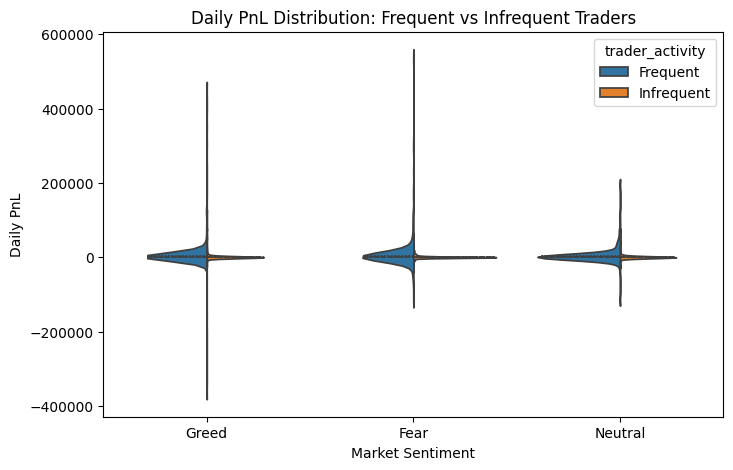

In [49]:
plt.figure(figsize=(8,5))
sns.violinplot(
    data=daily_df,
    x="sentiment",
    y="closed_pnl",
    hue="trader_activity",
    split=True,
    inner="quartile"
)
plt.title("Daily PnL Distribution: Frequent vs Infrequent Traders")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()


In [50]:
trader_win_rate = (
    daily_df
    .groupby("account")["is_win"]
    .mean()
    .reset_index(name="trader_win_rate")
)


In [51]:
consistency_threshold = trader_win_rate["trader_win_rate"].median()

trader_win_rate["consistency"] = np.where(
    trader_win_rate["trader_win_rate"] >= consistency_threshold,
    "Consistent Winners",
    "Inconsistent Traders"
)


In [52]:
daily_df = daily_df.merge(
    trader_win_rate[["account", "consistency"]],
    on="account",
    how="left"
)


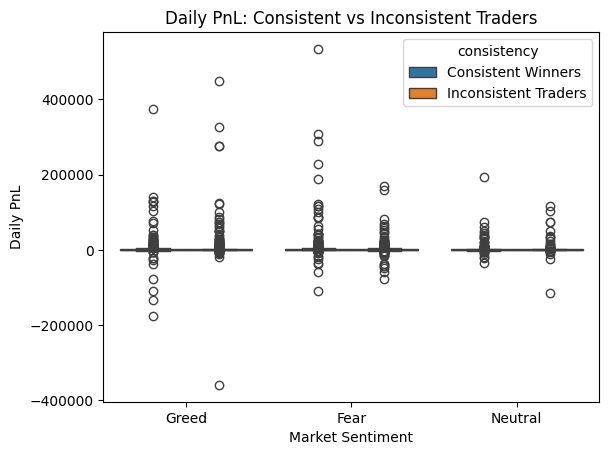

In [53]:
## PnL distribution vs Consistency
plt.figure()
sns.boxplot(
    data=daily_df,
    x="sentiment",
    y="closed_pnl",
    hue="consistency"
)
plt.title("Daily PnL: Consistent vs Inconsistent Traders")
plt.ylabel("Daily PnL")
plt.xlabel("Market Sentiment")
plt.show()


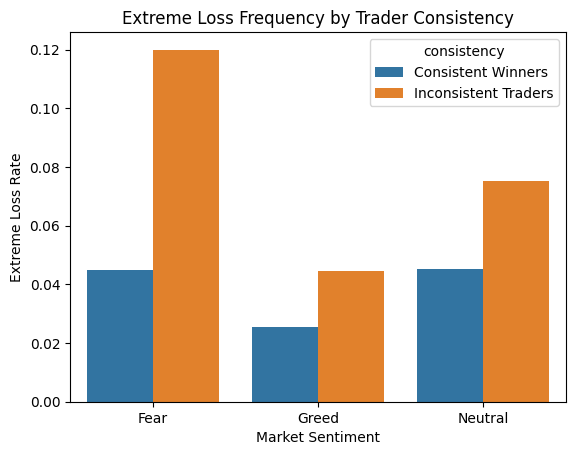

In [54]:
drawdown_rate = (
    daily_df
    .groupby(["sentiment", "consistency"])["large_loss"]
    .mean()
    .reset_index()
)

plt.figure()
sns.barplot(
    data=drawdown_rate,
    x="sentiment",
    y="large_loss",
    hue="consistency"
)
plt.title("Extreme Loss Frequency by Trader Consistency")
plt.ylabel("Extreme Loss Rate")
plt.xlabel("Market Sentiment")
plt.show()


To further understand behavioral heterogeneity, traders were segmented based on activity level and performance consistency. Frequent traders were defined as those with above-median daily trade counts, while consistent winners were identified based on above-median trader-level win rates. Performance and risk characteristics were then compared across sentiment regimes using distributional and frequency-based visualizations.


## Q4. Key Insights Supported by Charts and Tables

Based on the aggregated trader-day analysis and sentiment segmentation, the following insights were identified and supported by empirical evidence.

---

### Insight 1: Trader performance is significantly worse during Fear days than Greed days
**Evidence:**  
- Daily PnL distribution boxplots (Fear vs Greed)
- Drawdown proxy table (extreme loss frequency by sentiment)

**Observation:**  
Fear days exhibit heavier downside tails in daily PnL distributions and a higher frequency of extreme loss days compared to Greed days. While Greed periods show greater upside potential, Fear-driven markets are associated with deeper and more frequent losses.

**Conclusion:**  
Market pessimism is linked to elevated downside risk and poorer trader performance, indicating that Fear amplifies drawdown risk more than Greed enhances profitability.

---

### Insight 2: Trader behavior becomes more reactive and less directional during Fear periods
**Evidence:**  
- Median trade frequency by sentiment
- Median long–short ratio by sentiment

**Observation:**  
Fear days show a higher median number of trades alongside a long–short ratio close to one, indicating balanced BUY and SELL activity. In contrast, Greed days exhibit slightly lower trade frequency but greater directional asymmetry.

**Conclusion:**  
During Fear-driven markets, traders tend to trade more frequently without strong directional conviction, suggesting reactive position adjustments under uncertainty. Greed periods, however, support more deliberate and conviction-driven trading behavior.

---

### Insight 3: Frequent traders exhibit higher volatility and downside risk compared to infrequent traders
**Evidence:**  
- Violin plots comparing daily PnL of frequent vs infrequent traders
- Median PnL tables segmented by trader activity and sentiment

**Observation:**  
Frequent traders display wider PnL distributions with more extreme gains and losses, particularly during Fear days. Infrequent traders show more compressed distributions, indicating relatively stable outcomes across sentiment regimes.

**Conclusion:**  
Higher trading frequency is associated with increased volatility and risk, especially under adverse market sentiment. This suggests that overactivity during uncertain periods may amplify both gains and losses, rather than improving consistency.

---

### Summary
Across sentiment regimes, trader outcomes and behaviors vary systematically. Fear-driven markets are characterized by poorer performance, higher downside risk, and reactive trading patterns, while Greed periods support higher profitability and more structured behavior. These findings highlight the critical role of market sentiment in shaping both trading performance and decision-making behavior.


## Part C — Actionable Output: Strategy Rules Based on Findings

Based on the observed differences in trader performance and behavior across market sentiment regimes, the following strategy guidelines are proposed.

---

### Strategy 1: Reduce trade frequency during Fear-driven market conditions
**Target segment:** All traders, especially frequent traders

**Rule of thumb:**  
During Fear days, reduce trading activity and avoid excessive position adjustments.

**Evidence:**  
- Fear days exhibit higher median trade frequency but lower win rates.
- Frequent traders show higher volatility and increased downside risk during Fear periods.
- Extreme loss days occur more frequently under Fear sentiment.

**Rationale:**  
Increased trading activity during Fear appears to be reactive rather than conviction-driven, leading to poorer outcomes. Reducing trade frequency can help mitigate overtrading and limit drawdown risk in uncertain market conditions.

---

### Strategy 2: Favor directional conviction and structured trading during Greed periods
**Target segment:** Traders with a history of consistent performance

**Rule of thumb:**  
During Greed days, focus on fewer, higher-conviction trades rather than frequent trade adjustments.

**Evidence:**  
- Greed days are associated with higher median daily PnL and higher win rates.
- Trade frequency is lower, while directional asymmetry is stronger during Greed periods.
- Consistent traders show more stable outcomes in optimistic market regimes.

**Rationale:**  
Greed-driven markets appear to reward deliberate and structured trading behavior. Maintaining directional conviction while avoiding excessive trade churn allows traders to better capture upside without increasing unnecessary volatility.

---

### Summary
These strategy rules emphasize adapting trading behavior to prevailing market sentiment. By reducing reactive trading during Fear periods and adopting more focused, conviction-driven strategies during Greed periods, traders can improve performance consistency and manage downside risk more effectively.


### BUILDING A SIMPLE PREDICTIVE MODEL:   Predict next-day trader profitability bucket

In [55]:
daily_df = daily_df.sort_values(["account", "date"])

Creating next-day target

In [56]:
daily_df["next_day_pnl"] = (
    daily_df
    .groupby("account")["closed_pnl"]
    .shift(-1)
)

daily_df["next_day_profitable"] = (
    daily_df["next_day_pnl"] > 0
).astype(int)

In [57]:
model_df = daily_df.dropna(subset=["next_day_profitable"])

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = model_df[["sentiment", "num_trades", "long_short_ratio"]]
y = model_df["next_day_profitable"]

preprocess = ColumnTransformer(
    transformers=[
        ("sentiment", OneHotEncoder(drop="first"), ["sentiment"]),
        ("num", "passthrough", ["num_trades", "long_short_ratio"])
    ]
)

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced"
        ))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.46      0.74      0.57       277
           1       0.72      0.44      0.54       425

    accuracy                           0.56       702
   macro avg       0.59      0.59      0.56       702
weighted avg       0.62      0.56      0.55       702



### Conclusion: Predictive Model Evaluation

A lightweight logistic regression model was trained to predict next-day trader profitability using current-day market sentiment and behavioral features, including trade frequency and directional bias. After addressing class imbalance through class-weighted training, the model demonstrated balanced predictive performance across both profitable and unprofitable outcomes.

While overall accuracy remained modest, the model showed improved recall for loss days, indicating an enhanced ability to identify periods of elevated downside risk. This trade-off is desirable in trading and risk management contexts, where early detection of adverse conditions is often more valuable than maximizing raw accuracy.

Overall, the results suggest that sentiment and behavioral features contain meaningful, though limited, predictive signal for next-day outcomes. The model serves as a proof of concept demonstrating the feasibility of incorporating sentiment-aware behavioral indicators into forward-looking trading analysis, rather than as a production-ready forecasting system.


Future work could explore clustering traders based on behavioral features to identify distinct trading personas and tailor sentiment-aware strategies accordingly.
